In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
import matplotlib

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tqdm import tqdm
matplotlib.rcParams['figure.figsize'] = [15, 15]

In [13]:
# constants
data_path = '/home/raghukul/github/Time_Series_Project/Data/apple_share_price.csv'

In [14]:
# FOR REPRODUCIBILITY
np.random.seed(7)

In [15]:
# IMPORTING DATASET 
dataset = pd.read_csv('../Data/apple_share_price.csv', usecols=[1,2,3,4])

In [16]:
# TAKING DIFFERENT INDICATORS FOR PREDICTION
ts_data = dataset.mean(axis = 1) # aka OHLC
n_samples = len(ts_data)

## Relative Ordering Test - kendalls coefficient

In [17]:
def kendall_coeff(ts_data, n):
    count = 0
    for i in tqdm(range(n)):
        for j in range(i+1, n):
            if(ts_data[i] > ts_data[j]):
                count += 1
    coeff = 1 - 4.0*count/((n)*(n-1.0))
    var   = (2.0*(2*n + 5.0))/((9.0*n*(n-1.0)))
    
    return coeff, var, coeff/var**0.5

In [18]:
kendall_coeff(ts_data.values, n_samples)
# if observed statistics is greater than 1.96 (tau alpha/2), then we reject null hypothesis
# trend present

100%|██████████| 1664/1664 [00:00<00:00, 4254.73it/s]


(0.6832502659697488, 0.0002676561512250027, 41.7629525799875)

## Parametric F test

In [19]:
def poly_trend(Y_data, n, k):
    X_data = [[] for i in range(n)]
    for i in range(n):
        for j in range(k):
            X_data[i].append(pow(i, j))
    model = LinearRegression(fit_intercept=True)
    model.fit(X_data, Y_data)
    pred = model.predict(X_data)
    return pred

In [20]:
pred = poly_trend(ts_data, len(ts_data), 7)
new_data = [ts_data[i]-pred[i] for i in range(len(ts_data))]

In [21]:
np.asarray(new_data).std()

10.505020429613902

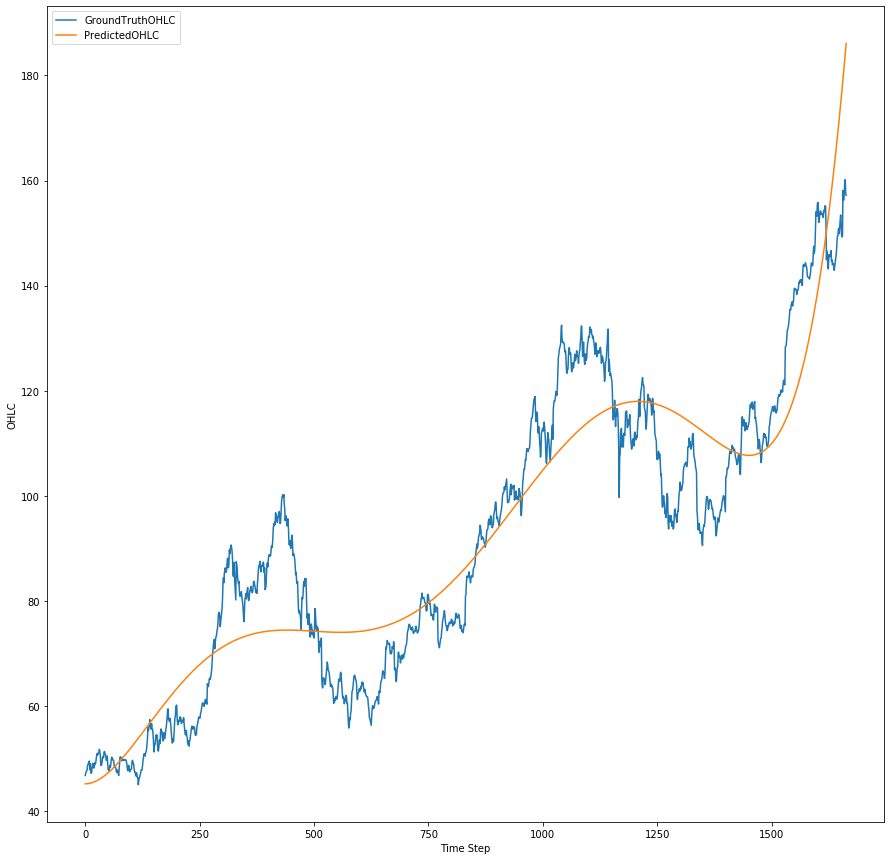

In [22]:
# at k = 7(6 degree trend), get lowest variance
plt.plot(ts_data,label='GroundTruthOHLC')
plt.plot(pred,label='PredictedOHLC')
plt.xlabel("Time Step")
plt.ylabel("OHLC")
plt.legend()

## Test for randomness

In [23]:
def randomness(ts_data):
    count = 0
    n = len(ts_data)
    for i in range(1, n-1):
        if(ts_data[i] > ts_data[i-1] and ts_data[i] > ts_data[i+1]):
            count += 1
        if(ts_data[i] < ts_data[i-1] and ts_data[i] < ts_data[i+1]):
            count += 1
    exp_q = (n-2.0)*(2/3.0)
    var_q = (16.0*n-29.0)/90.0
    z = (count - exp_q)/(var_q**0.5)
    return abs(z)

In [24]:
diff = []
for i in range(1, len(ts_data)):
    diff.append(ts_data[i] - ts_data[i-1])

In [25]:
diff2 = []
for i in range(1, len(diff)):
    diff2.append(diff[i] - diff[i-1])

In [26]:
# level 2 differencing gives best value
randomness(diff2)

1.5910187260149278

## Moving average - trend elimination

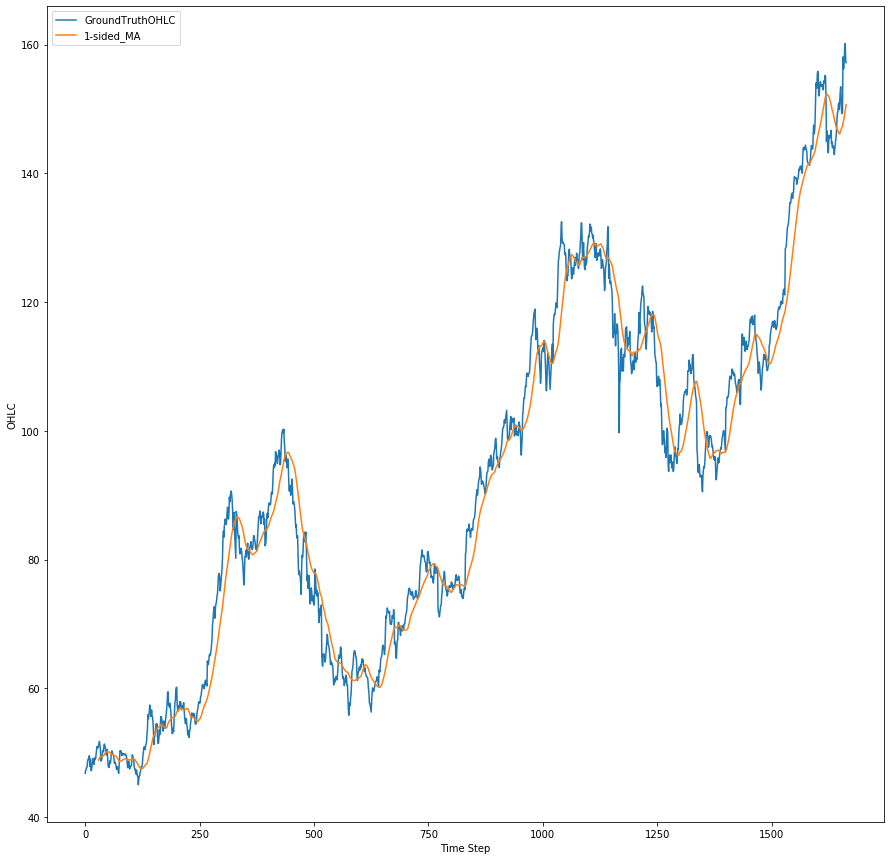

In [27]:
# l = ts_data.rolling(60).mean()[59:]
# print(l.std())
plt.plot(ts_data,label="GroundTruthOHLC")
plt.plot(ts_data.rolling(30).mean(),label='1-sided_MA')
plt.xlabel("Time Step")
plt.ylabel("OHLC")
plt.legend()

## Split the data

In [28]:
def split_data(OHLC_avg,ratio):
    train_OHLC = int(len(OHLC_avg) * ratio)
    test_OHLC = len(OHLC_avg) - train_OHLC
    train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]
    return train_OHLC, test_OHLC

## Preprocess the data for LSTM

In [51]:
def preprocess(dataset,step_size=1):
    data_X, data_Y = [], []
    for i in range(len(dataset)-step_size-1):
        a = dataset[i:(i+step_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + step_size, 0])
    return np.array(data_X), np.array(data_Y)

## LSTM Model

In [52]:
def Model(step_size=1):
    model = Sequential()
    model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
    model.add(LSTM(16))
    model.add(Dense(1))
    model.add(Activation('linear'))
    return model

In [53]:
OHLC_avg = np.reshape(ts_data.values, (len(ts_data),1)) # 1664
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)
train_OHLC, test_OHLC = split_data(OHLC_avg,0.75)
trainX, trainY = preprocess(train_OHLC, 1)
testX, testY = preprocess(test_OHLC, 1)

In [54]:
###Reshape to make it compatible to LSTM input
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# print(trainX)

In [55]:
model = Model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 32)             4352      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 7,505
Trainable params: 7,505
Non-trainable params: 0
_________________________________________________________________
None


In [56]:
model.compile(loss='mean_squared_error', optimizer='adagrad') # Try SGD, adam, adagrad and compare!!!
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Train on 1246 samples
Epoch 1/50
1246/1246 - 8s - loss: 0.0755
Epoch 2/50
1246/1246 - 3s - loss: 0.0357
Epoch 3/50
1246/1246 - 3s - loss: 0.0280
Epoch 4/50
1246/1246 - 4s - loss: 0.0253
Epoch 5/50
1246/1246 - 3s - loss: 0.0234
Epoch 6/50
1246/1246 - 3s - loss: 0.0217
Epoch 7/50
1246/1246 - 4s - loss: 0.0202
Epoch 8/50
1246/1246 - 4s - loss: 0.0187
Epoch 9/50
1246/1246 - 5s - loss: 0.0174
Epoch 10/50
1246/1246 - 7s - loss: 0.0161
Epoch 11/50
1246/1246 - 6s - loss: 0.0149
Epoch 12/50
1246/1246 - 6s - loss: 0.0138
Epoch 13/50
1246/1246 - 6s - loss: 0.0127
Epoch 14/50
1246/1246 - 6s - loss: 0.0117
Epoch 15/50
1246/1246 - 5s - loss: 0.0107
Epoch 16/50
1246/1246 - 6s - loss: 0.0098
Epoch 17/50
1246/1246 - 4s - loss: 0.0090
Epoch 18/50
1246/1246 - 4s - loss: 0.0082
Epoch 19/50
1246/1246 - 4s - loss: 0.0075
Epoch 20/50
1246/1246 - 4s - loss: 0.0068
Epoch 21/50
1246/1246 - 4s - loss: 0.0062
Epoch 22/50
1246/1246 - 4s - loss: 0.0056
Epoch 23/50
1246/1246 - 4s - loss: 0.0051
Epoch 24/50
1246/1246

In [57]:
### Prediction
step_size=1
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [58]:
### Denormalize
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [59]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

Train RMSE: 2.67
Test RMSE: 3.76


In [60]:
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict
OHLC_avg = scaler.inverse_transform(OHLC_avg)

In [61]:
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict

Text(0, 0.5, 'OHLC Value of Apple Stocks')

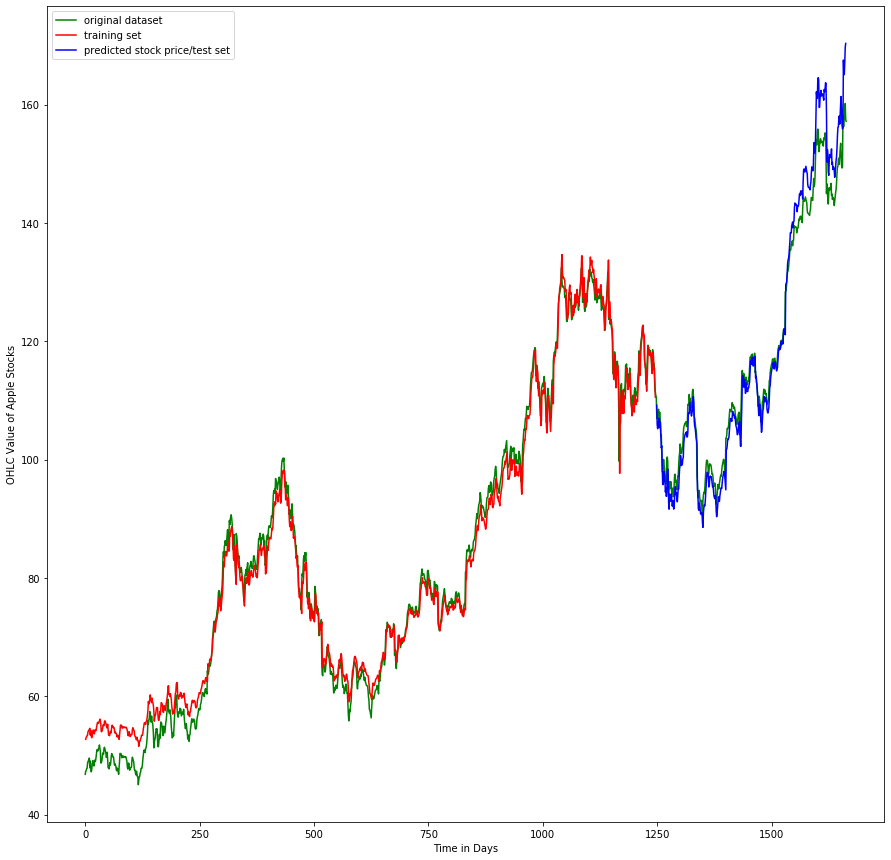

In [62]:
plt.plot(OHLC_avg, 'g', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper left')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of Apple Stocks')

## AR Model

In [63]:
def get_pred(X,order):
    rho, sigma = statsmodels.regression.yule_walker(X, order=order, method="mle")
    return rho,sigma

In [64]:
OHLC_avg2 = np.reshape(ts_data.values, (len(ts_data),1))
train_OHLC, test_OHLC = split_data(OHLC_avg2,0.75)

In [65]:
order = 2
rho,sigma = get_pred(train_OHLC,order)
pred_train = []
for i in range(order, len(train_OHLC)):
    sm = 0
    for j in range(order):
        sm += rho[j]*train_OHLC[i-j-1]
    pred_train.append(sm)

In [66]:
pred_test = []
for i in range(order, len(test_OHLC)):
    sm = 0
    for j in range(order):
        sm += rho[j]*test_OHLC[i-j-1]
    pred_test.append(sm)

In [67]:
step_size=1
trainPredictPlot1 = np.empty_like(OHLC_avg2)
trainPredictPlot1[:, :] = np.nan
trainPredictPlot1[step_size:len(pred_train)+step_size, :] = pred_train

In [68]:
testPredictPlot1 = np.empty_like(OHLC_avg2)
testPredictPlot1[:, :] = np.nan
testPredictPlot1[len(pred_train)+(step_size*2)+1:len(OHLC_avg2)-1, :] = pred_test

Text(0, 0.5, 'OHLC Value of Apple Stocks')

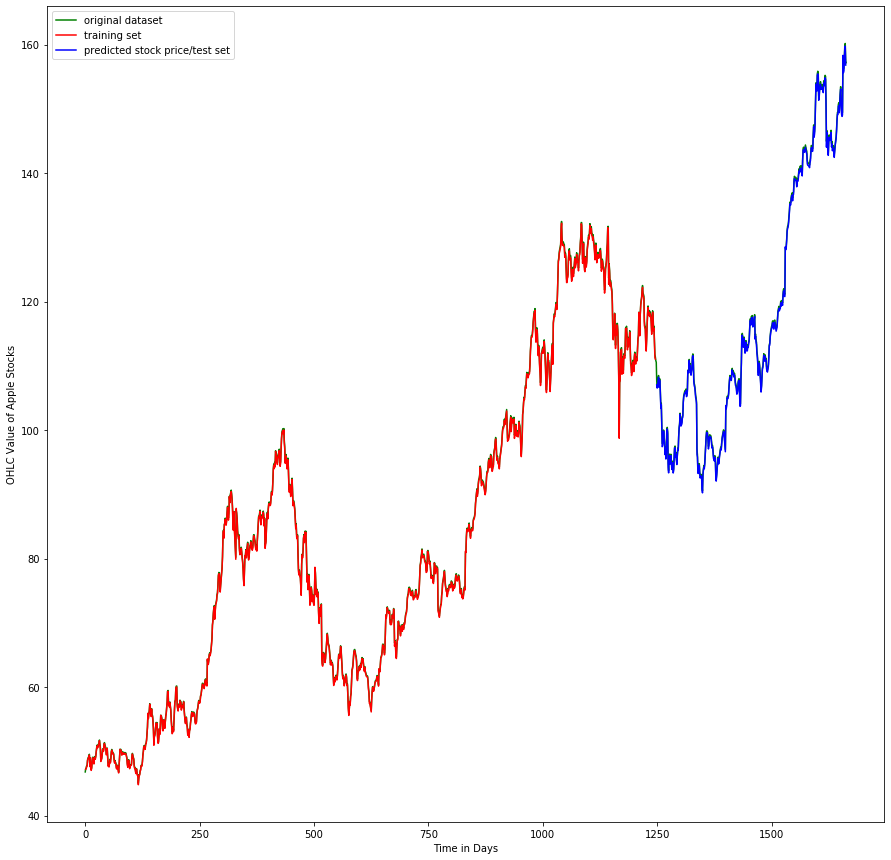

In [69]:
plt.plot(OHLC_avg2, 'g', label = 'original dataset')
plt.plot(trainPredictPlot1, 'r', label = 'training set')
plt.plot(testPredictPlot1, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper left')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of Apple Stocks')

In [ ]:
# print(pred2)
plt.plot(ts_data.values[order:],c='b', label="OHLC")
plt.plot()
plt.plot(pred2,c='r', label="prediction")
plt.legend()

# pred = get_pred(diff,2)
# plt.plot(diff[order:],c='b', label="OHLC")
# plt.plot(pred,c='r', label="prediction")
# plt.legend()